In [1]:
import numpy as np
from numpy import sin, cos, sinh, cosh, pi, sqrt
from bikewheelcalc import BicycleWheel
from IPython.display import display

import bikewheellib as bl
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def v_RT_rad(th, l_vv, l_ww, C=None):
    'Radial displacement under radial point load'

    g, a, b = solve_roots(l_vv, l_ww)

    if C is None:
        D, E, F = solve_BCs(l_vv, l_ww)
    else:
        D, E, F = (C[0], C[1], C[2])
    
    return (D*cosh(g*th) + E*cos(a*th)*cosh(b*th) +
            F*sin(a*th)*sinh(b*th))

def w_RT_rad(th, l_vv, l_ww, C=None):
    'Tangential displacement under radial point load'

    g, a, b = solve_roots(l_vv, l_ww)
    
    if C is None:
        D, E, F = solve_BCs(l_vv, l_ww)
    else:
        D, E, F = (C[0], C[1], C[2])
    
    return (D/g*sinh(g*th) +
            (E*b - F*a)/(a**2 + b**2)*cos(a*th)*sinh(b*th) +
            (E*a + F*b)/(a**2 + b**2)*sin(a*th)*cosh(b*th))

def solve_roots(l_vv, l_ww):

    r2 = np.roots([1., 2, 1 + l_vv, -l_ww])

    # Find which root is real
    r_real = r2[np.isreal(r2)][0]
    r_cplx = r2[np.iscomplex(r2)][0]

    g = np.sqrt(np.abs(r_real))
    a = np.sqrt(r_cplx).imag
    b = np.sqrt(r_cplx).real

    return [g, a, b]

def solve_BCs(l_vv, l_ww):
    'Solve boundary conditions for radial-tangential problem.'

    g, a, b = solve_roots(l_vv, l_ww)

    D = 2*a*b*g/sinh(g*pi)
    E = -(b*(a**2+b**2-g**2)*sin(a*pi)*cosh(b*pi) + a*(a**2+b**2+g**2)*cos(a*pi)*sinh(b*pi)) /\
        (cosh(b*pi)**2 - cos(a*pi)**2)

    F = -(a*(a**2+b**2+g**2)*sin(a*pi)*cosh(b*pi) - b*(a**2+b**2-g**2)*cos(a*pi)*sinh(b*pi)) /\
        (cosh(b*pi)**2 - cos(a*pi)**2)

    C = (D, E, F)

    # Numerically integrate to find Z
    tt = np.linspace(0., np.pi, 1000)
    Z = 2./pi * np.trapz(v_RT_rad(tt, l_vv, l_ww, C)*cos(tt) + l_ww/l_vv*w_RT_rad(tt, l_vv, l_ww, C)*sin(tt), tt)

    return (D/Z, E/Z, F/Z)

def v_RT_tan(th, l_vv, l_ww):
    'Radial displacement under tangential point load.'
    
    g, a, b = solve_roots(l_vv, l_ww)
    
    D, E, F = solve_BCs(l_vv, l_ww)
    A, B, C = (D/g, (E*b-F*a)/(a**2+b**2), (E*a+F*b)/(a**2+b**2))
    
    return l_ww/l_vv*(A*sinh(g*th) + B*cos(a*th)*sinh(b*th) +
                      C*sin(a*th)*cosh(b*th))

def w_RT_tan(th, l_vv, l_ww, C=None):
    'Tangential displacement under tangential point load.'
    
    g, a, b = solve_roots(l_vv, l_ww)
    
    D, E, F = solve_BCs(l_vv, l_ww)
    A, B, C = (D/g, (E*b-F*a)/(a**2+b**2), (E*a+F*b)/(a**2+b**2))
    
    return l_ww/l_vv*(A/g*cosh(g*th) +
                      (B*b - C*a)/(a**2 + b**2)*cos(a*th)*cosh(b*th) +
                      (B*a + C*b)/(a**2 + b**2)*sin(a*th)*sinh(b*th))

def v_Het(th, l_vv):
    eta = sqrt(l_vv + 1)
    a = sqrt((eta-1)/2)
    b = sqrt((eta+1)/2)
    
    A = (a*cosh(a*pi)*sin(b*pi) + b*sinh(a*pi)*cos(b*pi)) / \
        (eta*(sinh(a*pi)**2 + sin(b*pi)**2))
    B = (a*sinh(a*pi)*cos(b*pi) - b*cosh(a*pi)*sin(b*pi)) / \
        (eta*(sinh(a*pi)**2 + sin(b*pi)**2))
        
    v = pi/(4*a*b)*l_vv * (2*a*b/(pi*eta**2) -
                           A*cosh(a*th)*cos(b*th) +
                           B*sinh(a*th)*sin(b*th))
    return v

In [3]:
wh = BicycleWheel()
wh.hub = wh.Hub(diam1=0.05, width1=0.020, width2=0.040)

R = 0.304
GJ = 25.0
EI1 = 100
EI2 = GJ / 0.1

wh.rim = wh.Rim(radius=0.304,
              area=100e-6,
              I11=GJ / 26.0e9,
              I22=EI2 / 69.0e9,  # 266.0
              I33=EI1 / 69.0e9,
              Iw=0.0 / 69.0e9,
              young_mod=69.0e9,
              shear_mod=26.0e9)

wh.lace_cross(n_spokes=36, n_cross=3, diameter=2.0e-3, young_mod=200e9, offset=0.0)

k_spokes = bl.calc_continuum_stiff(wh)
k_vv = k_spokes[1, 1]
k_ww = k_spokes[2, 2]

l_vv = k_vv*R**4/EI1
l_ww = k_ww*R**4/EI1

[-0.45328467192033928, -0.23473841935937156, -0.010625762342228978, 0.053374400506899504]


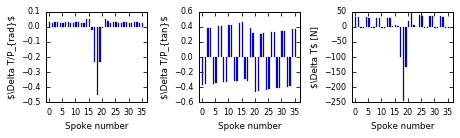

In [4]:
with plt.style.context(('seaborn-paper')):
    fig, ax = plt.subplots(ncols=3, figsize=(6.5, 2))
    
    # Spoke numbers
    s_num = (np.arange(36)-18)%36
    
    # Calculate change in spoke tension for radial load
    delta_T = [s.EA/s.length *\
               s.n.dot(np.array([0.,
                                 1./(pi*R*k_vv) * v_RT_rad(s.rim_pt[1] - pi, l_vv, l_ww),
                                 1./(pi*R*k_vv) * w_RT_rad(s.rim_pt[1] - pi, l_vv, l_ww)]))
               for s in wh.spokes]
    
    ax[0].set_xlim([-1, 37])
    ax[0].bar(s_num, delta_T, width=0.5)
    ax[0].set_xlabel('Spoke number')
    ax[0].set_ylabel('\$\Delta T/P_{rad}\$')
    
    print delta_T[0:4]
    
    # Calculate change in spoke tension for radial load

    delta_T = [s.EA/s.length *\
               s.n.dot(np.array([0.,
                                 1./(pi*R*k_ww) * v_RT_tan(s.rim_pt[1] - pi, l_vv, l_ww),
                                 1./(pi*R*k_ww) * w_RT_tan(s.rim_pt[1] - pi, l_vv, l_ww)]))
               for s in wh.spokes]
    
    ax[1].set_xlim([-1, 37])
    ax[1].bar(s_num, delta_T, width=0.5)
    ax[1].set_xlabel('Spoke number')
    ax[1].set_ylabel('\$\Delta T/P_{tan}\$')
    
    
    # Calculate change in spoke tension for radial load
    P_rad = 500
    P_tan = -50

    delta_T = [s.EA/s.length *\
               s.n.dot(np.array([0.,
                                 (P_rad/(pi*R*k_vv) * v_RT_rad(s.rim_pt[1] - pi, l_vv, l_ww) +
                                  P_tan/(pi*R*k_ww) * v_RT_tan(s.rim_pt[1] - pi, l_vv, l_ww)),
                                 (P_rad/(pi*R*k_vv) * w_RT_rad(s.rim_pt[1] - pi, l_vv, l_ww) +
                                  P_tan/(pi*R*k_ww) * w_RT_tan(s.rim_pt[1] - pi, l_vv, l_ww))]))
               for s in wh.spokes]
    
    ax[2].set_xlim([-1, 37])
    ax[2].bar(s_num, delta_T, width=0.5)
    ax[2].set_xlabel('Spoke number')
    ax[2].set_ylabel('\$\Delta T\$ [N]')


plt.tight_layout()
plt.savefig('../figs/stress_analysis/_python_rad_tan_Tinf.pdf')

# Check that $w'=v$ by numerical integration

-2.13365658475e-10
-2.1336543643e-10
-2.13364714785e-10
-2.1336687972e-10


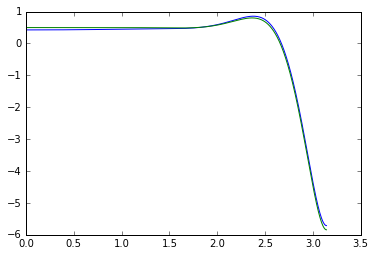

In [5]:
tt = np.linspace(0, np.pi, 1000)

plt.plot(tt, v_RT_rad(tt, 1000, 0.1*1000))
plt.plot(tt, v_Het(tt, 1000))

print np.trapz(v_RT_rad(tt, 1000, 0.01*1000), tt)
print np.trapz(v_RT_rad(tt, 1000, 0.1*1000), tt)
print np.trapz(v_RT_rad(tt, 1000, 1.0*1000), tt)
print np.trapz(v_Het(tt, 1000), tt)